# I will create an agent learn by playing with [other agent](https://www.kaggle.com/stonet2000/lux-ai-season-1-jupyter-notebook-tutorial) who follow a deterministic approach using reinforcement learning.

# Deep Q Network (DQN)

This notebook is to create an agent that works using Deep Q Network (DQN) over the generic Q Learning approach.

<!-- For submission check https://www.kaggle.com/aithammadiabdellatif/lux-submission -->
## Q Learning

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

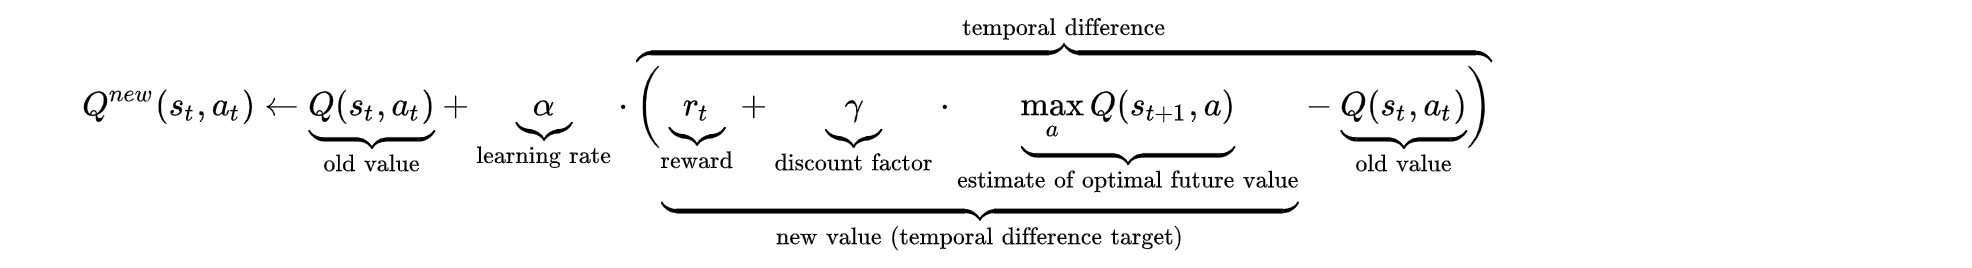

# Deep Q-Networks
In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output. The comparison between Q-learning & deep Q-learning is wonderfully illustrated below:

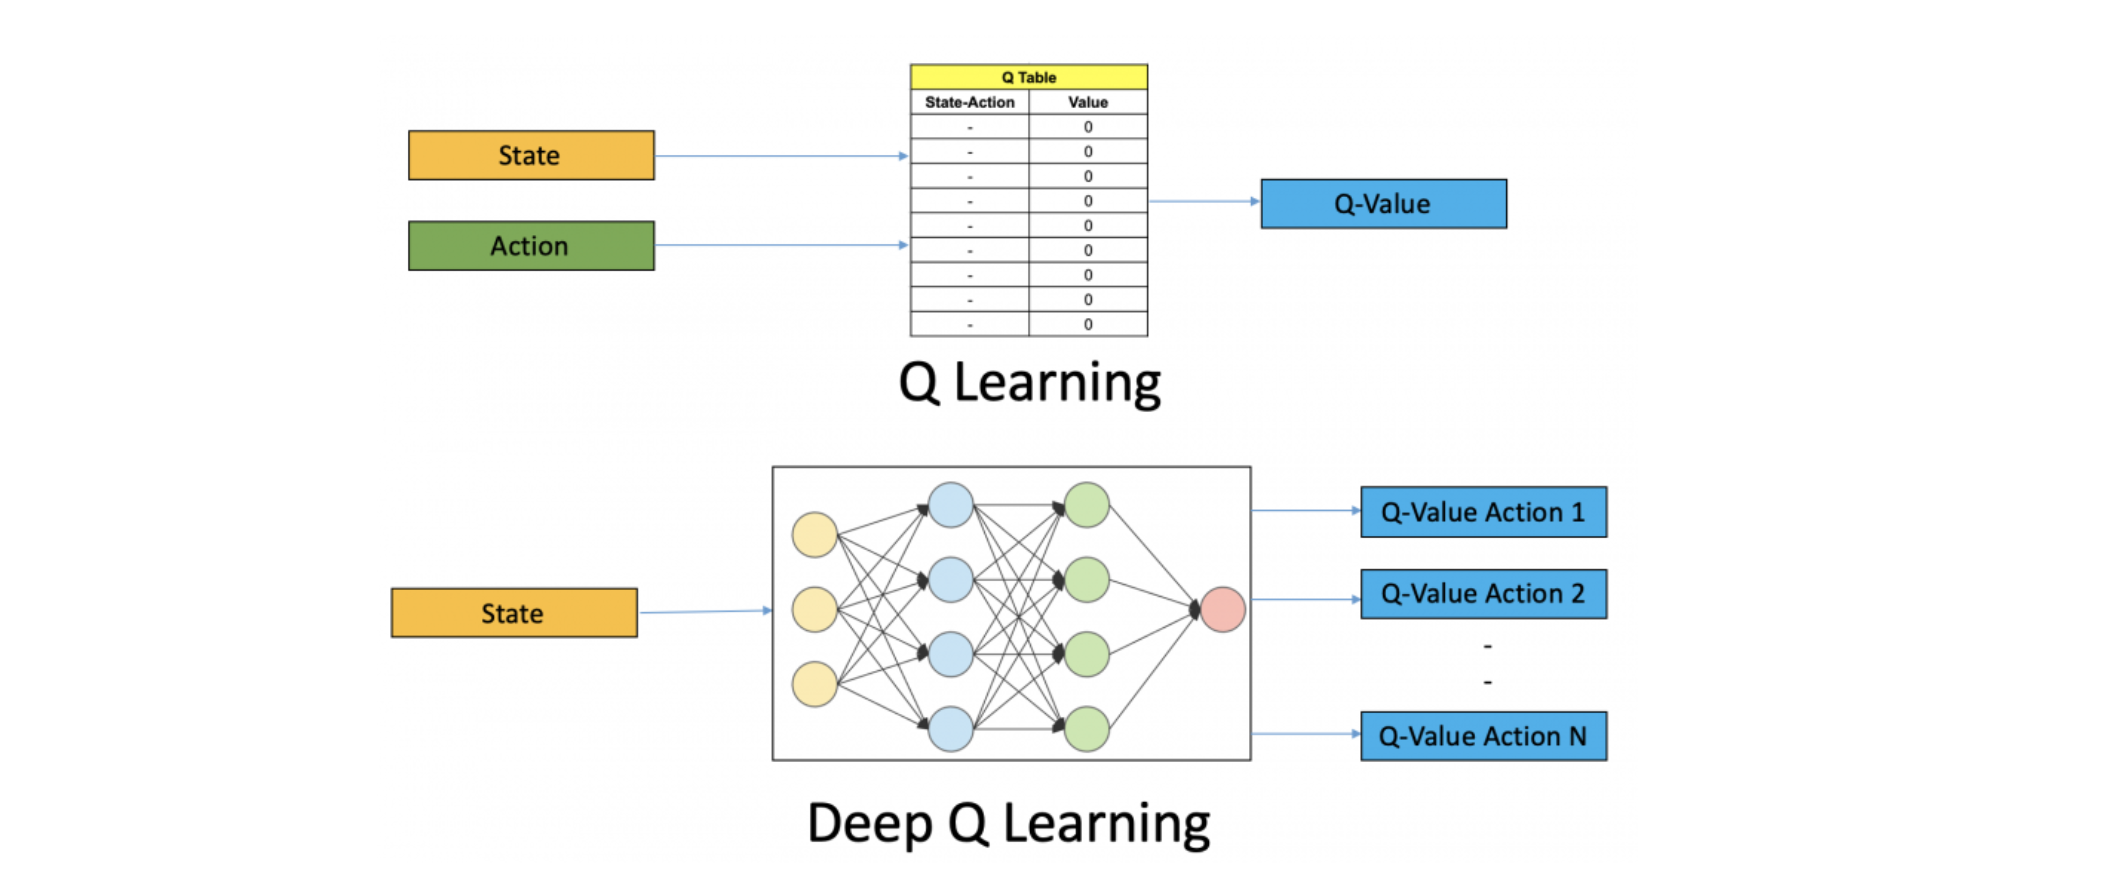

<!-- Steps involved in reinforcement learning using deep Q-learning networks (DQNs):

1. All the past experience is stored by the user in memory
2. The next action is determined by the maximum output of the Q-network
3. The loss function here is mean squared error of the predicted Q-value and the target Q-value – Q*. This is basically a regression problem. However, we do not know the target or actual value here as we are dealing with a reinforcement learning problem. Going back to the Q-value update equation derived fromthe Bellman equation. we have: -->

Thanks to :
[Reinforcement Learning:
An Introduction](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) and 
[
RPS: RL using Deep Q Network (DQN)](https://www.kaggle.com/anmolkapoor/rps-rl-using-deep-q-network-dqn)

In [ ]:
!pip install -q kaggle-environments -U

In [ ]:
from kaggle_environments import make
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math, sys
import numpy as np
import random
from IPython.display import clear_output 
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub
from collections import deque
import random
import math

In [ ]:
gamma = 0.95
epsilon = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
# we declare this global game_state object so that state persists across turns so we do not need to reinitialize it all the time
game_state = None


 # Define basic agent to invistigate the structure of input and output of the model

In [ ]:
# this is the basic agent definition. At the moment this agent does nothing (and actually will survive for a bit before getting consumed by darkness)
def agent(observation, configuration):
    global game_state
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
#         print("new episode")
    else:
        game_state._update(observation["updates"])
    
    actions = []

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
#     print(observation['reward'])

    return actions

we run one episode to take an example of the `game_state`. 

In [ ]:
# run another match but with our empty agent
env = make("lux_ai_2021", configuration={"seed": 562124210, "loglevel": 2}, debug=True)
steps = env.run([agent, agent])

# Strategy
The model will take as input the map of the game(width x height), with all feature of the cells, the output will be a map of cells, for every cell we will predict direction and ability to move, build, and others abilities can be made by the units.

# The input of the model 

In [ ]:
def get_inputs(game_state):
    # Teh shape of the map
    w,h = game_state.map.width, game_state.map.height
    # The map of ressources
    M = [ [0  if game_state.map.map[j][i].resource==None else game_state.map.map[j][i].resource.amount for i in range(w)]  for j in range(h)]
    
    M = np.array(M).reshape((h,w,1))
    
    # The map of units features
    U = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]
    units = game_state.players[0].units
    for i in units:
        U[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]

    U = np.array(U)
    
    # The map of cities featrues
    e = game_state.players[1].cities
    C = [ [[0,0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep,e[k].team]

    C = np.array(C)
#     print(M.shape,U.shape,C.shape)
    # stacking all in one array
    E = np.dstack([M,U,C])
    return E

input_shape = get_inputs(game_state).shape
# The shape of input
input_shape 

# Model

In [ ]:
def get_model(game_state):
    inputs = keras.Input(shape=get_inputs(game_state).shape,name = 'The game map')
    
    # Try to play with the next layers in order to enhance the brean of your agent
    c = layers.Conv2D(8,(1,1),activation = "relu")(inputs)
    c = layers.Conv2D(8,(1,1),activation = "relu")(c)
    c = layers.Conv2D(8,(1,1),activation = "relu")(c)
    
    # The next layer will define the direction among the 5 options, because we can take only one direction we had to use softmax activation
    output1 = layers.Dense(5,activation = "softmax",name ='direction')(c)
    
    # The next layer will define the option token by the unit (move, build,...), because one unit can take only one option we use sotmax activation
    output2 = layers.Dense(3,activation = "softmax",name="option" )(c)
    output = layers.concatenate([output1,output2])
    model = keras.Model(inputs = inputs, outputs = output)
    model.compile(loss='mse', optimizer="adam")
    return model

model =get_model(game_state)
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

# Predict actions

In [ ]:
x = get_inputs(game_state)
y = model.predict(np.asarray([x]))[0]
y.shape

The function will take the units of the game stat and predict the options and directions in case of move option gathered in actions list

In [ ]:
def get_prediction_actions(y,units):
    # move
    mv = np.argmax(y[:,:,:5],axis = 2) # the index in this list  [c s n w e]
    
    choice = np.argmax(y[:,:,5:],axis = 2)
    actions = []
    for i in units:
        d = "csnwe"[mv[i.pos.y,i.pos.x]]
        if choice[i.pos.y,i.pos.x]==0 and i.can_act():actions.append(i.move(d))
        elif choice[i.pos.y,i.pos.x]==1 and i.can_build(game_state.map):actions.append(i.build_city())
        elif choice[i.pos.y,i.pos.x]==2:actions.append(i.pillage())
        
    return actions,y[:,:,5:]
get_prediction_actions(y,game_state.players[0].units)[0]

# RL agent

In [ ]:
Last_State = {}

model = None
def agent(observation, configuration):
    global game_state,epsilon,model
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
        # Inistialise the model
        if not model:
            model= get_model(game_state)
            model.load_weights('../input/keras-lux-ai-weights/model.h5')
        
    else:
        game_state._update(observation["updates"])
    

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
#     print(width, height)

    # Get Prediction of actions
    x = get_inputs(game_state)
#     print(x.shape)
    y = model.predict(np.asarray([x]))[0]
    
    if random.random()<epsilon:
        y = np.random.rand(*y.shape)
    print("eps ",epsilon,end= " | ") 
    actions,_ = get_prediction_actions(y,player.units)
    
    print("Reward",observation["reward"])
    # Model Learing
    
    if observation.player in Last_State:
        _x,_y,_ = Last_State[observation.player]
        state,next_state,reward = _x,x,observation["reward"]
#         print(_y.shape,_.shape)
#         reward = sigmoid(reward)
        reward/=100000.
            
        reward = reward+ gamma * np.amax(_y,axis = 2)
        # print(reward.shape)

        for i in player.units:
            print(_y[i.pos.x,i.pos.y].shape,_[i.pos.x,i.pos.y].shape)
            _y[i.pos.y,i.pos.x][[0,1,2,3,4]] = reward[i.pos.x,i.pos.y]
            _y[i.pos.y,i.pos.x][5] = reward[i.pos.y,i.pos.x] if reward[i.pos.y,i.pos.x]>=0.5 else 1-reward[i.pos.y,i.pos.x]
            _y[i.pos.y,i.pos.x][6] = reward[i.pos.y,i.pos.x] if reward[i.pos.y,i.pos.x]>=0.5 else 1-reward[i.pos.y,i.pos.x]
            _y[i.pos.y,i.pos.x][7] = reward[i.pos.y,i.pos.x] if reward[i.pos.y,i.pos.x]>=0.5 else 1-reward[i.pos.y,i.pos.x]
        model.fit(np.asarray([state]),np.asarray([_y]), epochs=1, verbose=1)
        if epsilon > epsilon_final:
            epsilon*= epsilon_decay
    Last_State[observation.player] = [x,y,_]
    return actions

In [ ]:
episodes = 3

for eps in range(episodes):
    clear_output()
    print("=== Episode {} ===".format(eps))
    env = make("lux_ai_2021", configuration={"seed": 562124210, "loglevel": 2}, debug=True)
    steps = env.run(["../input/lux-ai-season-1-jupyter-notebook-tutorial/agent.py", agent])
    
# clear_output()

In [ ]:
env.render(mode="ipython", width=600, height=800)

Saving the model for submission

In [ ]:
model.save_weights("model.h5")


# Submission

In [ ]:
!cp -r ../input/lux-ai-2021/* .

In [ ]:
%%writefile agent.py
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math, sys
import numpy as np
import random
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random
import math

from pathlib import Path
p = Path('/kaggle_simulations/agent/')
if p.exists():
    sys.path.append(str(p))
else:
    p = Path('__file__').resolve().parent

gamma = 0.95
epsilon = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
# we declare this global game_state object so that state persists across turns so we do not need to reinitialize it all the time
game_state = None

model = None

def get_inputs(game_state):
    w,h = game_state.map.width, game_state.map.height
    M = [ [0  if game_state.map.map[j][i].resource==None else game_state.map.map[j][i].resource.amount for i in range(w)]  for j in range(h)]

    M = np.array(M).reshape((w,h,1))
    
    U = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]
    units = game_state.players[0].units
    for i in units:
        U[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]

    U = np.array(U)
    
    e = game_state.players[1].cities
    C = [ [[0,0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep,e[k].team]

    C = np.array(C)
    E = np.dstack([M,U,C])
    return E


def get_model(game_state):
    input_shape = get_inputs(game_state).shape
    print(input_shape)
    inputs = keras.Input(shape=input_shape)
    c = layers.Conv2D(8,(1,1),activation = "relu")(inputs)
    c = layers.Conv2D(8,(1,1),activation = "relu")(c)
    c = layers.Conv2D(8,(1,1),activation = "relu")(c)
    output1 = layers.Dense(5,activation = "softmax")(c)
    output2 = layers.Dense(3,activation = "softmax")(c)
    output = layers.concatenate([output1,output2])
    model = keras.Model(inputs = inputs, outputs = output)
    model.compile(loss='mse', optimizer="adam")
    return model



def get_prediction_actions(y,units):
    # move
    mv = np.argmax(y[:,:,:5],axis = 2) # the index in this list  [c s n w e]
    
    choice = np.argmax(y[:,:,5:],axis = 2)
    actions = []
    for i in units:
        d = "csnwe"[mv[i.pos.y,i.pos.x]]
        if choice[i.pos.y,i.pos.x]==0:actions.append(i.move(d))
        elif choice[i.pos.y,i.pos.x]==1 and i.can_build(game_state.map):actions.append(i.build_city())
        elif choice[i.pos.y,i.pos.x]==2:actions.append(i.pillage())
        
    return actions,y[:,:,5:]


def agent(observation, configuration):
    global game_state,epsilon,model
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
        print("Creating model..")
        model =get_model(game_state)
        print("Load model weight..")
        try:
            model.load_weights( str(p/'model.h5'),  by_name=True, skip_mismatch=True)
        except Exception as e:
            print('Error in model load')
            print(e)
#         model = tf.keras.models.load_model('model.h5')
        print("Done crating mdoel")
        
        
    else:
        game_state._update(observation["updates"])
    

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height

    # Get Prediction of actions
    x = get_inputs(game_state)
    y = model.predict(np.asarray([x]))[0]
    actions,_ = get_prediction_actions(y,player.units)
    return actions

In [ ]:
# replay = env.toJSON()
# with open("replay.json", "w") as f:
#     json.dump(replay, f)
!tar -czf submission.tar.gz *
# !rm lux -r

In [ ]:
from kaggle_environments import make
import json
# run another match but with our empty agent
env = make("lux_ai_2021", configuration={"seed": 56221, "loglevel": 2}, debug=True)
steps = env.run(["./agent.py", "./agent.py"])

In [ ]:
env.render(mode="ipython", width=600, height=800)

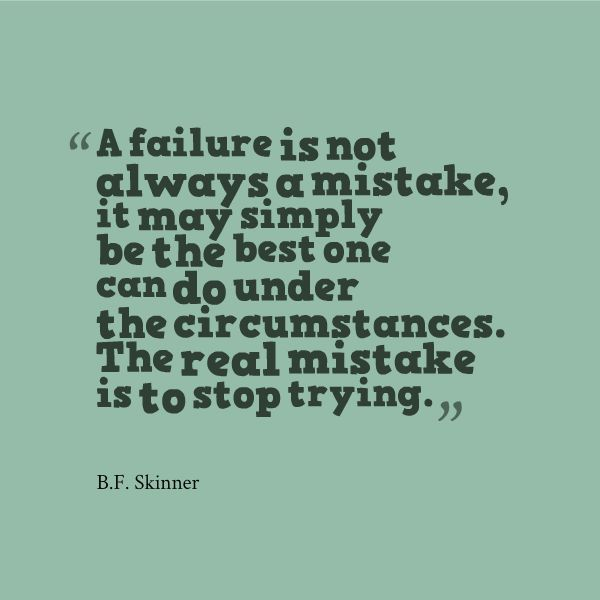

In [ ]:
# from tensorflow import keras
from tensorflow.keras import layers